In [50]:
from scipy.spatial import KDTree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Load datasets
dataset1 = pd.read_csv("data/workout_fitness_tracker_data.csv")
dataset2 = pd.read_csv("data/health_fitness_dataset.csv")

dataset1["BMI"] = dataset1["Weight (kg)"] / ((dataset1["Height (cm)"] / 100) ** 2)

# Standardize Gender Labels
gender_map = {"Male": "M", "Female": "F", "Other": "Other"}  # Keep "Other"
dataset1["Gender"] = dataset1["Gender"].map(gender_map)

# Rename Dataset 2 columns for consistency
dataset2 = dataset2.rename(columns={
    "age": "Age",
    "height_cm": "Height (cm)",
    "weight_kg": "Weight (kg)",
    "resting_heart_rate": "Resting Heart Rate (bpm)",
    "bmi": "BMI",
    "gender": "Gender"
})

# Define matching features & their weights
features = ["Age", "Height (cm)", "Weight (kg)", "Resting Heart Rate (bpm)", "BMI"]
feature_weights = np.array([1, 1, 1, 3, 3])  # More weight for Resting HR & BMI

# Separate "Other" from gender-based matching
gender_groups = ["M", "F"]
merged_dataframes = []

for gender in gender_groups:  # Match "M" to "M" and "F" to "F"
    ds1_filtered = dataset1[dataset1["Gender"] == gender].copy()
    ds2_filtered = dataset2[dataset2["Gender"] == gender].copy()

    if ds2_filtered.empty or ds1_filtered.empty:
        print(f"⚠️ No matching users found in Dataset 2 for gender: {gender}")
        continue

    # Extract & normalize features
    scaler = MinMaxScaler()
    ds1_scaled = scaler.fit_transform(ds1_filtered[features]) * feature_weights
    ds2_scaled = scaler.transform(ds2_filtered[features]) * feature_weights

    # KD-Tree for nearest-neighbor search
    kd_tree = KDTree(ds2_scaled)
    distances, best_matches = kd_tree.query(ds1_scaled, k=1)

    # Merge results
    best_match_df = ds2_filtered.iloc[best_matches].reset_index(drop=True)
    merged_df = ds1_filtered.reset_index(drop=True).copy()

    # Keep Dataset 1 values and add only unique columns from Dataset 2
    ds2_unique_cols = [col for col in dataset2.columns if col not in dataset1.columns]
    merged_df[ds2_unique_cols] = best_match_df[ds2_unique_cols].values
    merged_df["Match Distance"] = distances  # Lower = better match

    merged_dataframes.append(merged_df)

# Handle "Other" separately (match based on closest features, ignoring gender)
ds1_other = dataset1[dataset1["Gender"] == "Other"].copy()
if not ds1_other.empty:
    scaler = MinMaxScaler()
    ds1_other_scaled = scaler.fit_transform(ds1_other[features]) * feature_weights
    ds2_all_scaled = scaler.transform(dataset2[features]) * feature_weights  # Match to all dataset2 users

    kd_tree = KDTree(ds2_all_scaled)
    distances, best_matches = kd_tree.query(ds1_other_scaled, k=1)

    best_match_df = dataset2.iloc[best_matches].reset_index(drop=True)
    merged_other = ds1_other.reset_index(drop=True).copy()

    # Add unique columns from Dataset 2
    merged_other[ds2_unique_cols] = best_match_df[ds2_unique_cols].values
    merged_other["Match Distance"] = distances  # Lower = better match

    merged_dataframes.append(merged_other)

# Combine results
final_merged_dataset = pd.concat(merged_dataframes, ignore_index=True)


In [51]:
print(final_merged_dataset.columns)

Index(['User ID', 'Age', 'Gender', 'Height (cm)', 'Weight (kg)',
       'Workout Type', 'Workout Duration (mins)', 'Calories Burned',
       'Heart Rate (bpm)', 'Steps Taken', 'Distance (km)', 'Workout Intensity',
       'Sleep Hours', 'Water Intake (liters)', 'Daily Calories Intake',
       'Resting Heart Rate (bpm)', 'VO2 Max', 'Body Fat (%)',
       'Mood Before Workout', 'Mood After Workout', 'BMI', 'participant_id',
       'date', 'activity_type', 'duration_minutes', 'intensity',
       'calories_burned', 'avg_heart_rate', 'hours_sleep', 'stress_level',
       'daily_steps', 'hydration_level', 'blood_pressure_systolic',
       'blood_pressure_diastolic', 'health_condition', 'smoking_status',
       'fitness_level', 'Match Distance'],
      dtype='object')


In [52]:

final_merged_dataset = final_merged_dataset.drop(columns=['duration_minutes', 'calories_burned', 'avg_heart_rate', 
                      'daily_steps', 'Match Distance', 'hours_sleep', 
                      'hydration_level', 'intensity', 'participant_id', 'date', 'activity_type', 'fitness_level'])

# Display the updated DataFrame
print(final_merged_dataset.columns)

Index(['User ID', 'Age', 'Gender', 'Height (cm)', 'Weight (kg)',
       'Workout Type', 'Workout Duration (mins)', 'Calories Burned',
       'Heart Rate (bpm)', 'Steps Taken', 'Distance (km)', 'Workout Intensity',
       'Sleep Hours', 'Water Intake (liters)', 'Daily Calories Intake',
       'Resting Heart Rate (bpm)', 'VO2 Max', 'Body Fat (%)',
       'Mood Before Workout', 'Mood After Workout', 'BMI', 'stress_level',
       'blood_pressure_systolic', 'blood_pressure_diastolic',
       'health_condition', 'smoking_status'],
      dtype='object')


In [53]:
final_merged_dataset.rename(columns={
    'stress_level': 'Stress Level',
    'blood_pressure_systolic': 'Blood Pressure Systolic',
    'blood_pressure_diastolic': 'Blood Pressure Diastolic',
    'health_condition': 'Health Condition',
    'smoking_status': 'Smoking Status'
}, inplace=True)

# Display the updated DataFrame
print(final_merged_dataset.columns)

Index(['User ID', 'Age', 'Gender', 'Height (cm)', 'Weight (kg)',
       'Workout Type', 'Workout Duration (mins)', 'Calories Burned',
       'Heart Rate (bpm)', 'Steps Taken', 'Distance (km)', 'Workout Intensity',
       'Sleep Hours', 'Water Intake (liters)', 'Daily Calories Intake',
       'Resting Heart Rate (bpm)', 'VO2 Max', 'Body Fat (%)',
       'Mood Before Workout', 'Mood After Workout', 'BMI', 'Stress Level',
       'Blood Pressure Systolic', 'Blood Pressure Diastolic',
       'Health Condition', 'Smoking Status'],
      dtype='object')


In [54]:
print(final_merged_dataset.dtypes)

User ID                       int64
Age                           int64
Gender                       object
Height (cm)                   int64
Weight (kg)                   int64
Workout Type                 object
Workout Duration (mins)       int64
Calories Burned               int64
Heart Rate (bpm)              int64
Steps Taken                   int64
Distance (km)               float64
Workout Intensity            object
Sleep Hours                 float64
Water Intake (liters)       float64
Daily Calories Intake         int64
Resting Heart Rate (bpm)      int64
VO2 Max                     float64
Body Fat (%)                float64
Mood Before Workout          object
Mood After Workout           object
BMI                         float64
Stress Level                 object
Blood Pressure Systolic      object
Blood Pressure Diastolic     object
Health Condition             object
Smoking Status               object
dtype: object


In [55]:
print(final_merged_dataset.isnull().sum())

User ID                        0
Age                            0
Gender                         0
Height (cm)                    0
Weight (kg)                    0
Workout Type                   0
Workout Duration (mins)        0
Calories Burned                0
Heart Rate (bpm)               0
Steps Taken                    0
Distance (km)                  0
Workout Intensity              0
Sleep Hours                    0
Water Intake (liters)          0
Daily Calories Intake          0
Resting Heart Rate (bpm)       0
VO2 Max                        0
Body Fat (%)                   0
Mood Before Workout            0
Mood After Workout             0
BMI                            0
Stress Level                   0
Blood Pressure Systolic        0
Blood Pressure Diastolic       0
Health Condition            6763
Smoking Status                 0
dtype: int64


In [56]:
# Mbush vlerat që mungojnë në kolonën 'Health Condition' me "Not Specified"
final_merged_dataset["Health Condition"] = final_merged_dataset["Health Condition"].fillna("Not Specified")

print(final_merged_dataset.isnull().sum())

User ID                     0
Age                         0
Gender                      0
Height (cm)                 0
Weight (kg)                 0
Workout Type                0
Workout Duration (mins)     0
Calories Burned             0
Heart Rate (bpm)            0
Steps Taken                 0
Distance (km)               0
Workout Intensity           0
Sleep Hours                 0
Water Intake (liters)       0
Daily Calories Intake       0
Resting Heart Rate (bpm)    0
VO2 Max                     0
Body Fat (%)                0
Mood Before Workout         0
Mood After Workout          0
BMI                         0
Stress Level                0
Blood Pressure Systolic     0
Blood Pressure Diastolic    0
Health Condition            0
Smoking Status              0
dtype: int64


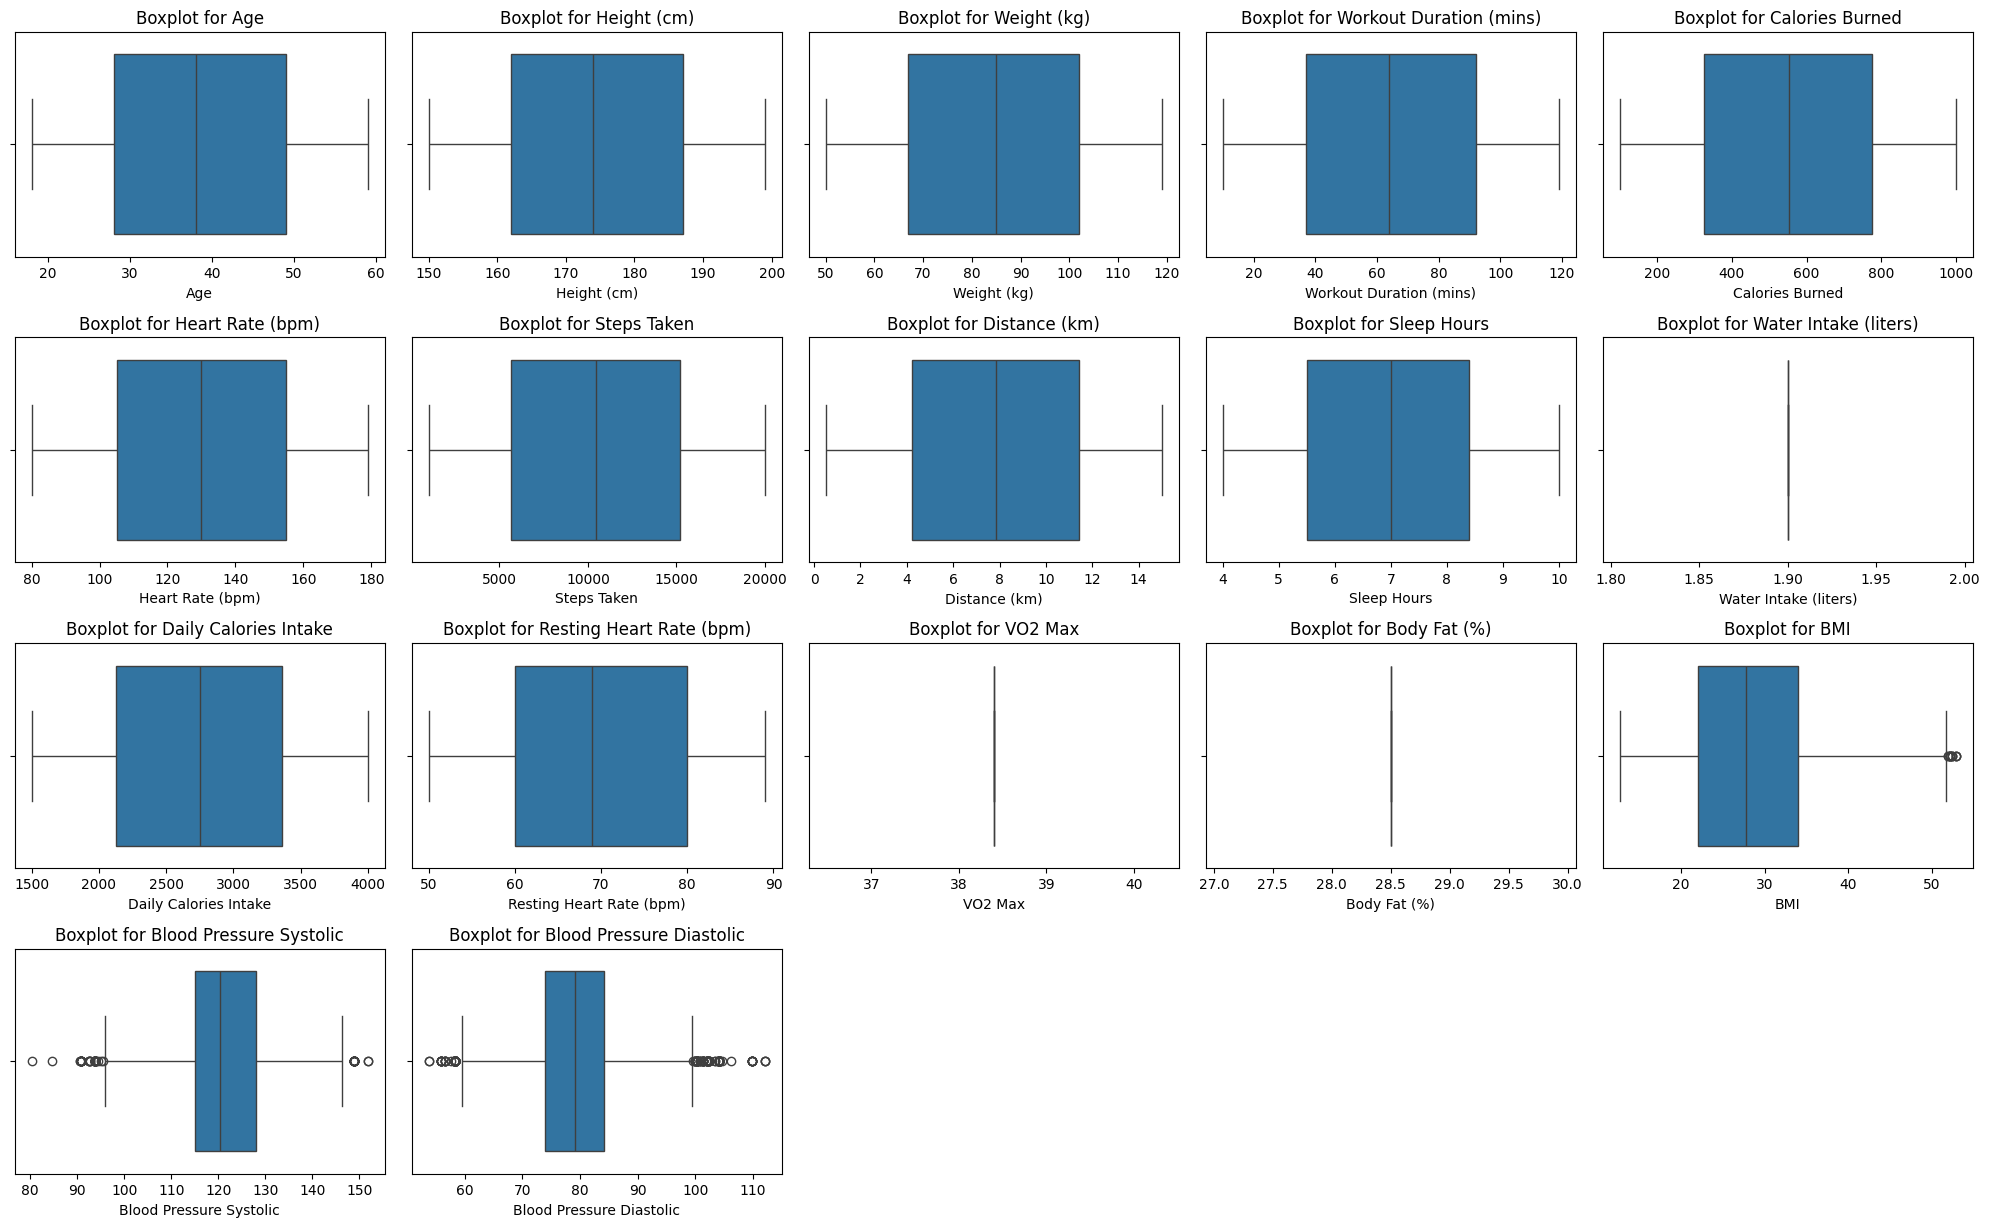

In [57]:
# Boxplot për të parë shpërndarjen dhe outliers me grid më të madh (5x5)
plt.figure(figsize=(20, 15))  # Zgjedhje e madhësisë së figurës
for i, column in enumerate(numerical_cols, 1):
    plt.subplot(5, 5, i)  # Përdorimi i një gridi 5x5
    sns.boxplot(data=final_merged_dataset, x=column)
    plt.title(f'Boxplot for {column}')
    plt.tight_layout()

plt.show()

In [58]:
final_merged_dataset.drop(["Water Intake (liters)", "Body Fat (%)", "VO2 Max"], axis=1, inplace=True)

# Funksioni për të larguar outliers duke përdorur IQR
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Filtrimi i të dhënave brenda kufijve të IQR-së
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Largimi i outliers për kolona specifike
final_merged_dataset = remove_outliers_iqr(final_merged_dataset, "BMI")
final_merged_dataset = remove_outliers_iqr(final_merged_dataset, "Blood Pressure Systolic")
final_merged_dataset = remove_outliers_iqr(final_merged_dataset, "Blood Pressure Diastolic")

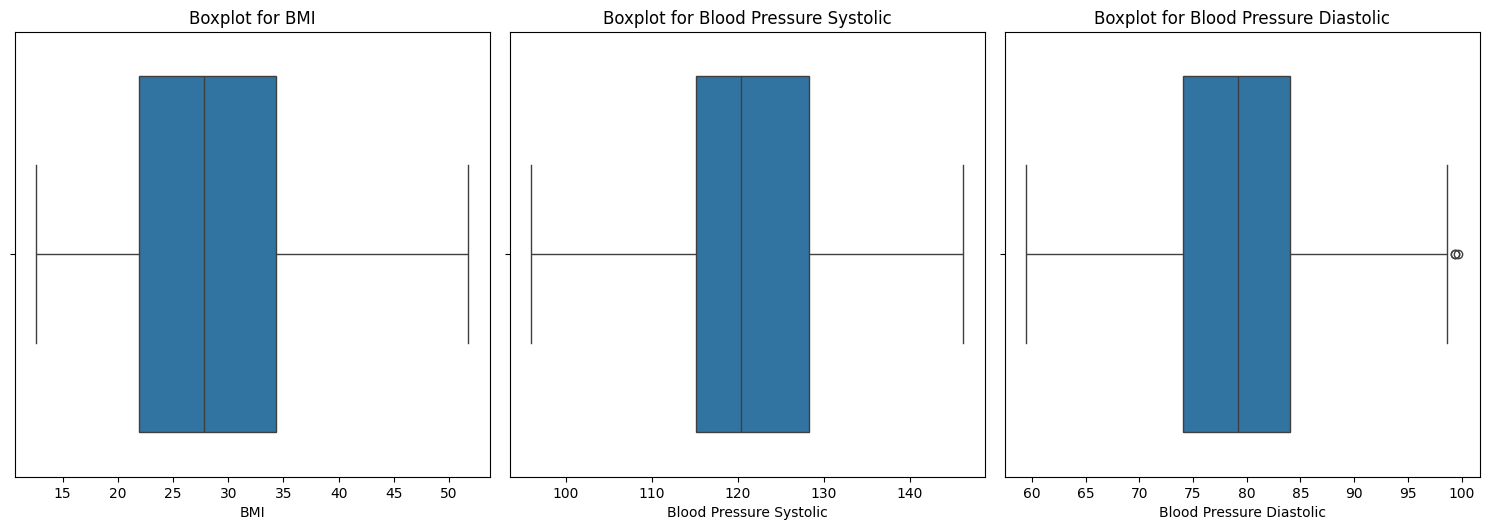

In [59]:
# Cakto kolonat që do të shfaqen
cols_to_plot = ["BMI", "Blood Pressure Systolic", "Blood Pressure Diastolic"]

# Boxplot për secilën kolone
plt.figure(figsize=(15, 10))
for i, column in enumerate(cols_to_plot, 1):
    plt.subplot(2, 3, i)  # Grid 2x3 për 3 kolona
    sns.boxplot(data=final_merged_dataset, x=column)
    plt.title(f'Boxplot for {column}')
    plt.tight_layout()

plt.show()

Index(['User ID', 'Age', 'Gender', 'Height (cm)', 'Weight (kg)',
       'Workout Duration (mins)', 'Calories Burned', 'Heart Rate (bpm)',
       'Steps Taken', 'Distance (km)', 'Sleep Hours', 'Daily Calories Intake',
       'Resting Heart Rate (bpm)', 'Mood Before Workout', 'Mood After Workout',
       'BMI', 'Stress Level', 'Blood Pressure Systolic',
       'Blood Pressure Diastolic', 'Health Condition', 'Smoking Status',
       'Workout Type_Cycling', 'Workout Type_HIIT', 'Workout Type_Running',
       'Workout Type_Strength', 'Workout Type_Yoga', 'Workout Intensity_Low',
       'Workout Intensity_Medium'],
      dtype='object')


In [64]:
# Save final dataset
final_merged_dataset.to_csv("merged_dataset_filter_by_gender3.csv", index=False)

print("✅ Matching completed (including 'Other' category)! Data saved as merged_dataset.csv")

✅ Matching completed (including 'Other' category)! Data saved as merged_dataset.csv
